In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import random
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from utils.preprocess import batch_norm, batch_norm_inverse
from utils.visuals import vis_one_var_recon
from utils.metrics import lat_weighted_rmse_one_var

2024-07-02 22:14:05.730350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 22:14:05.822613: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 22:14:06.538644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-02 22:14:06.538687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Data

In [3]:
resolution_folder = '56degree'
resolution = '5.625'  
var_num = '5'

train_data_tf = np.load("data/concat_2006_2015_" + resolution + "_" + var_num + "var.npy")
val_data_tf = np.load("data/concat_2016_2016_" + resolution + "_" + var_num + "var.npy")
test_data_tf = np.load("data/concat_2017_2018_" + resolution + "_" + var_num + "var.npy")

(14608, 5, 32, 64) (1464, 5, 32, 64) (2920, 5, 32, 64)


In [4]:
X_train = data_train.transpose((0, 2, 3, 1))
X_val = data_val.transpose((0, 2, 3, 1))
X_test = data_test.transpose((0, 2, 3, 1))

print(X_train.shape, X_val.shape, X_test.shape)

(14608, 32, 64, 5) (1464, 32, 64, 5) (2920, 32, 64, 5)


### Data normalization

In [5]:
X_train_norm = batch_norm(X_train, X_train.shape, batch_size=1460)
X_val_norm = batch_norm(X_val, X_val.shape, batch_size=1460)
X_test_norm = batch_norm(X_test, X_test.shape, batch_size=1460)

print(X_train_norm.shape, X_val_norm.shape, X_test_norm.shape)

(14608, 32, 64, 5) (1464, 32, 64, 5) (2920, 32, 64, 5)


### Model

In [11]:
def encoder_net(input_shape):
    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (2, 2), activation='relu', padding='same', strides=1)(encoder_inputs)
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same', strides=1)(x)
    x = layers.Conv2D(256, (2, 2), activation='relu', padding='same', strides=1)(x)

    x = layers.Conv2D(512, (2, 2), activation='relu', padding='same', strides=1, name='bottleneck')(x)

    x = layers.Conv2D(256, (2, 2), activation='relu', padding='same', strides=1)(x)
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same', strides=1)(x)
    x = layers.Conv2D(5, (2, 2), activation='relu', padding='same', strides=1)(x)
    
    encoder = keras.Model(encoder_inputs, [x], name='encoder_net')
    return encoder

In [12]:
input_shape = (32, 64, 5)
model = encoder_net(input_shape)
model.summary()

Model: "encoder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 64, 5)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 64, 32)        672       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 64, 128)       16512     
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 64, 256)       131328    
                                                                 
 bottleneck (Conv2D)         (None, 32, 64, 512)       524800    
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 64, 256)       524544    
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 64, 128)       

### Training

In [12]:
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate
                                                         )

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse')

# model.compile(optimizer='adam',
#     # optimizer=Adam(learning_rate=lr_schedule),
#              loss='mse', 
#             )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)
mc = ModelCheckpoint('../saved_models/encoder_cnn_56deg_5var.h5', 
                     monitor='val_loss', 
                     mode='min',
                     save_best_only=True,
                    )

model.fit(X_train_norm, X_train_norm, 
          validation_data=(X_val_norm, X_val_norm),
          epochs=100, 
          batch_size=128,
          # verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/100


2024-06-28 01:01:14.152726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-28 01:01:14.204664: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-28 01:01:15.043278: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x96e77e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-28 01:01:15.043299: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-06-28 01:01:15.047389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-28 01:01:15.110584: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-28 01:01:15.124685: I tensorflow/compiler/jit/xla_compilation_cach

115/115 [==============================] - ETA: 0s - loss: 0.0342
Epoch 1: val_loss improved from inf to 0.00470, saving model to ../saved_models/encoder_cnn_56deg_5var.h5
115/115 [==============================] - 11s 69ms/step - loss: 0.0342 - val_loss: 0.0047
Epoch 2/100
114/115 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 2: val_loss improved from 0.00470 to 0.00317, saving model to ../saved_models/encoder_cnn_56deg_5var.h5
115/115 [==============================] - 7s 60ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 3/100
114/115 [============================>.] - ETA: 0s - loss: 0.0032
Epoch 3: val_loss improved from 0.00317 to 0.00257, saving model to ../saved_models/encoder_cnn_56deg_5var.h5
115/115 [==============================] - 7s 61ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 4/100
114/115 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss improved from 0.00257 to 0.00190, saving model to ../saved_models/encoder_cnn_56deg_5

### Reconstruction test

In [13]:
saved_model = load_model('../saved_models/encoder_cnn_56deg_5var.h5', 
                         # custom_objects={'RandomMaskingLayer': RandomMaskingLayer, 'lat_weighted_loss_mse':lat_weighted_loss_mse}
                        )
X_recon_norm = saved_model.predict(X_test_norm)
# X_recon_norm.shape

2024-07-02 22:20:13.605059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-07-02 22:20:13.660537: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


92/92 [==============================] - 1s 6ms/step


In [14]:
X_recon = batch_norm_inverse(X_test, X_recon_norm, X_recon_norm.shape, 1460)

In [15]:
# `X_min_per_channel` and `X_max_per_channel` are the min and max values per channel
# X_recon = X_recon_norm * (X_max_per_channel - X_min_per_channel) + X_min_per_channel
X_recon.shape

(2920, 32, 64, 5)

### Postprocessing

In [16]:
Z500_idx = 0
T850 = 1
T2m_idx = -3
U10_idx = -2
V10_idx = -1

resolution = 2.8125*2

In [18]:
dict = {"Z500":0, "T850":1, "T2m":-3, "U10":-2, "V10":-1}

for var, var_idx in dict.items():
    print(f'{var} RMSE: {lat_weighted_rmse_one_var(X_recon, X_test, var_idx=var_idx, resolution=resolution):.2f}')

Z500 RMSE: 62.71
T850 RMSE: 0.36
T2m RMSE: 0.55
U10 RMSE: 0.25
V10 RMSE: 0.21


#### Z500

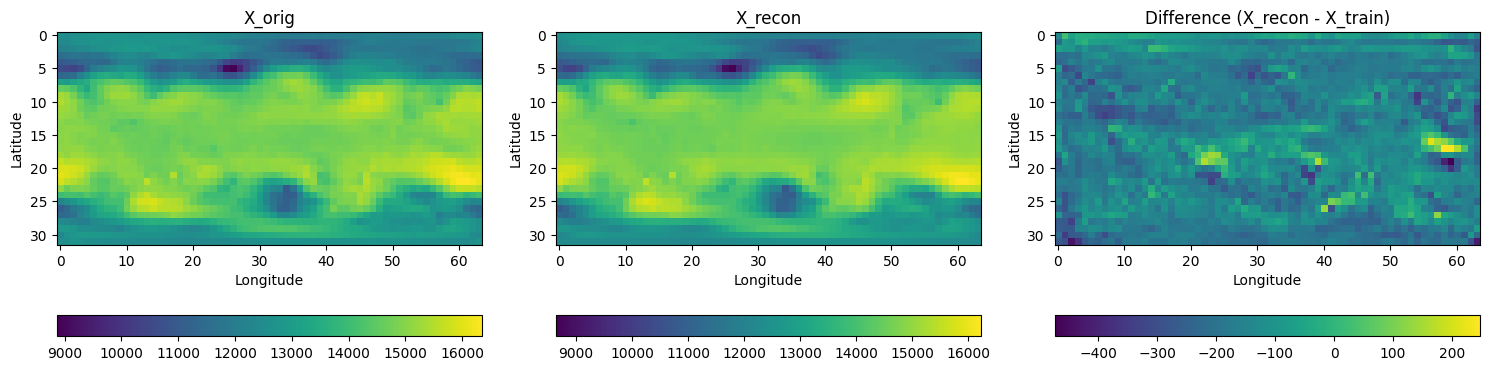

In [14]:
vis_one_var_recon(X_recon, X_test, sample_idx=0, var_idx=0)

In [15]:
lat_weighted_rmse_one_var(X_recon, X_test, var_idx=0, resolution=2.8125*2)

161.03876

#### T850

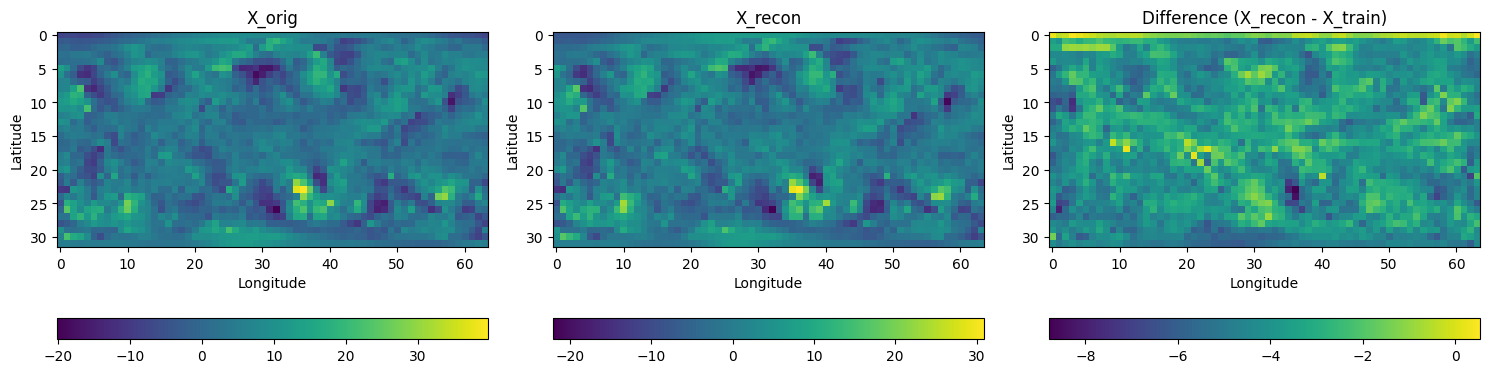

In [16]:
vis_one_var_recon(X_recon, X_test, sample_idx=0, var_idx=3)

In [17]:
lat_weighted_rmse_one_var(X_recon, X_test, var_idx=1, resolution=2.8125*2)

1.683424

#### U10

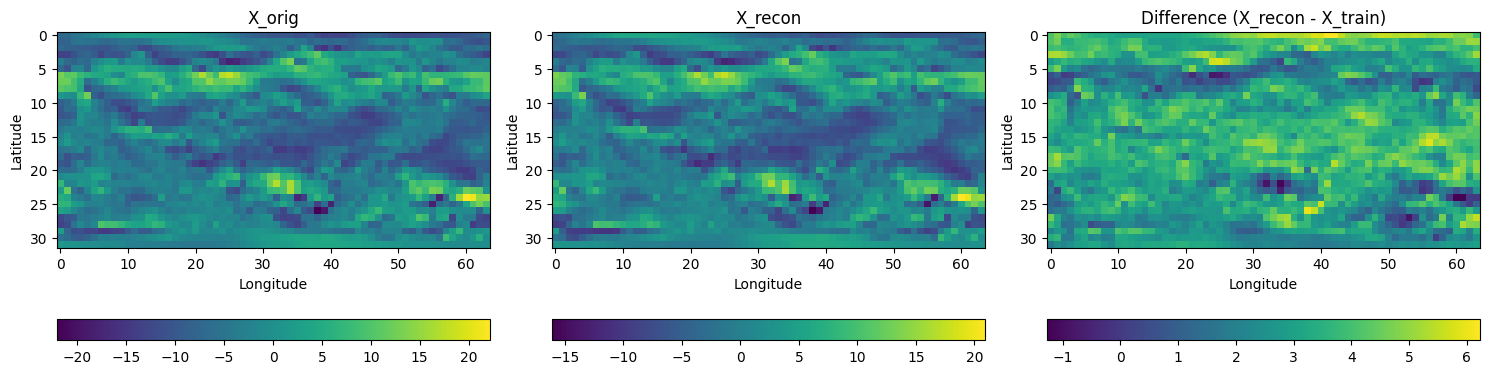

In [18]:
vis_one_var_recon(X_recon, X_test, sample_idx=0, var_idx=-2)

In [19]:
lat_weighted_rmse_one_var(X_recon, X_test, var_idx=-2, resolution=2.8125*2)

3.2314334

#### V10

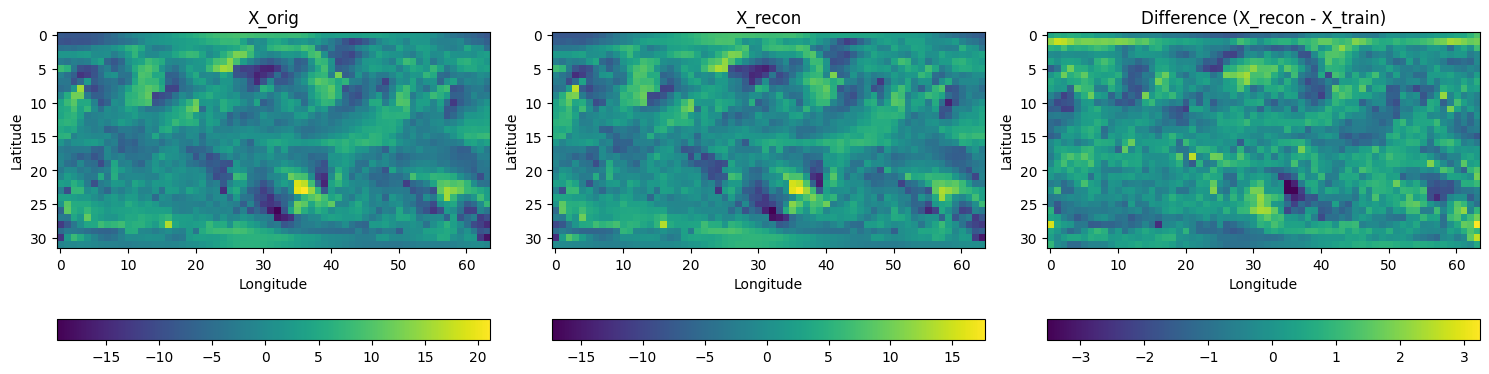

In [20]:
vis_one_var_recon(X_recon, X_test, sample_idx=0, var_idx=-1)

In [21]:
lat_weighted_rmse_one_var(X_recon, X_test, var_idx=-1, resolution=2.8125*2)

0.8448625

#### T2m

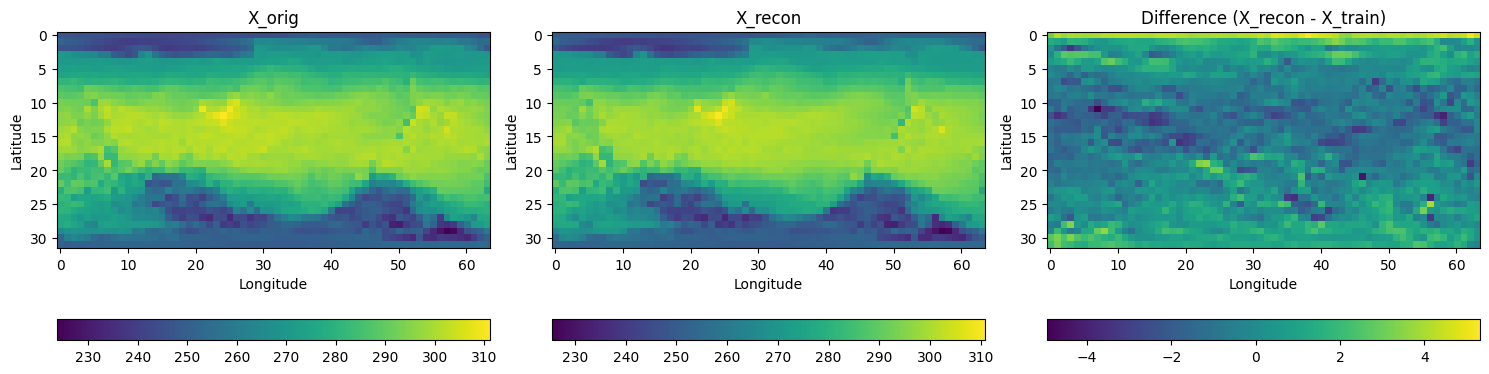

In [22]:
vis_one_var_recon(X_recon, X_test, sample_idx=0, var_idx=-3)

In [23]:
lat_weighted_rmse_one_var(X_recon, X_test, var_idx=-3, resolution=2.8125*2)

1.2891234

In [36]:

latitudes = tf.constant([-88.59375, -85.78125, -82.96875, -80.15625, -77.34375, -74.53125,
                      -71.71875, -68.90625, -66.09375, -63.28125, -60.46875, -57.65625,
                      -54.84375, -52.03125, -49.21875, -46.40625, -43.59375, -40.78125,
                      -37.96875, -35.15625, -32.34375, -29.53125, -26.71875, -23.90625,
                      -21.09375, -18.28125, -15.46875, -12.65625, -9.84375, -7.03125,
                      -4.21875, -1.40625, 1.40625, 4.21875, 7.03125, 9.84375,
                      12.65625, 15.46875, 18.28125, 21.09375, 23.90625, 26.71875,
                      29.53125, 32.34375, 35.15625, 37.96875, 40.78125, 43.59375,
                      46.40625, 49.21875, 52.03125, 54.84375, 57.65625, 60.46875,
                      63.28125, 66.09375, 68.90625, 71.71875, 74.53125, 77.34375,
                      80.15625, 82.96875, 85.78125, 88.59375
                     ], dtype=tf.float32)
# degree --> radians
lat_radians = latitudes * (tf.constant(3.141592653589793, dtype=tf.float32) / 180.0)
print(lat_radians.shape)

cosine_lat = tf.math.cos(lat_radians)
print(cosine_lat.shape)

# Normalize weights
L = cosine_lat / tf.reduce_mean(cosine_lat)
print(L.shape)

(64,)
(64,)
(64,)


In [37]:
# Expand the dimension for compatibility
L_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(L, axis=0), axis=2), axis=3)  # (1, H, 1, 1) for (N, H, W, C) 
print(L_expanded.shape)

(1, 64, 1, 1)


In [41]:
# Calculate squared error and apply latitude weighting factor
squared_error = tf.square(X_recon - X_test)
print(squared_error.shape)

weighted_squared_error = squared_error * L_expanded
print(weighted_squared_error.shape)

(1460, 64, 128, 15)
(1460, 64, 128, 15)


In [45]:
# Calculate mean over all dimensions except the channel dimension
weighted_error = tf.reduce_mean(weighted_squared_error)
weighted_error.numpy()

7253.3057